<a href="https://colab.research.google.com/github/Lakshmanaraja/Teaching-Deep-Learning/blob/main/Image_Classifier_Resnet_From_Scratch_FastAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch  #Import necessary libraries
import torch.nn 

In [2]:
!pip install -Uqq fastbook #Install Fastbook for fast ai libraries


     |████████████████████████████████| 720 kB 4.0 MB/s 
     |████████████████████████████████| 189 kB 50.8 MB/s 
     |████████████████████████████████| 1.2 MB 45.9 MB/s 
     |████████████████████████████████| 48 kB 4.4 MB/s 
     |████████████████████████████████| 55 kB 3.8 MB/s 
     |████████████████████████████████| 51 kB 321 kB/s 
     |████████████████████████████████| 558 kB 40.3 MB/s 
     |████████████████████████████████| 130 kB 50.2 MB/s 


In [3]:
import fastbook
from fastbook import * #Importing fast ai libraries

In [4]:
#Function to return DataLoader from the URL with specified size
def get_data(url,presize,resize):
  path = untar_data(url)
  return DataBlock(blocks=(ImageBlock , CategoryBlock ), get_items=get_image_files, splitter = GrandparentSplitter(valid_name='val'), 
                   get_y = parent_label , item_tfms = Resize(presize), 
                   batch_tfms = [*aug_transforms(min_scale = 0.5 , size=resize), Normalize.from_stats(*imagenet_stats)],).dataloaders(path,bs=128)


In [5]:
#Initialising Imagenette Data Loader
dls = get_data(URLs.IMAGENETTE_160,160,128)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


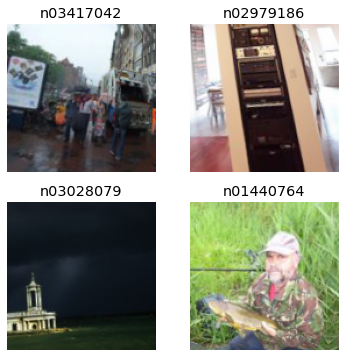

In [6]:
#Some sample of Dataset
dls.show_batch(max_n=4)

In [9]:
#Resnet Block class with covolution and identity convolution along with pooling layer
class ResBlock(Module):
  def __init__(self,ni,nf, stride=1):
    
    self.convs = _conv_block(ni,nf,stride) #Normal Convolution layer
    self.idconv = noop if ni==nf else ConvLayer(ni,nf,1, act_cls=None) #Identity Mapping for ResNet used to match the dimensions of I/P and O/P
    self.pool = noop if stride==1 else nn.AvgPool2d(2,ceil_mode=True) #

  def forward(self,x):
    return F.relu(self.convs(x) + self.idconv(self.pool(x))) #Resnet - x + convs(x) 

In [10]:
#Returns a block of Stride 2 and additional block of Stride 1 with Batch Gamma set to zero used to deepen the network
def _conv_block(ni,nf,stride):
  return nn.Sequential(ConvLayer(ni,nf,stride=stride), ConvLayer(nf,nf,act_cls=None, norm_type= NormType.BatchZero))
  

In [11]:
def block(ni,nf): #return ResBlock(ni,nf,stride=2)  #One Resblock contains - 3 Convolutions Normal + Batch zero conv + Identity Mapping
      return nn.Sequential(ResBlock(ni,nf,stride=2),ResBlock(nf,nf)) #Twice times of Resblock to form a really deep layer

In [12]:
#Returns Learner object for given dataloader and model along with Loss Function and error metric
def get_learner(m):
  return Learner(dls,m,loss_func=nn.CrossEntropyLoss(),metrics = accuracy).to_fp16()

In [13]:
#Returns Convolution Model
def get_model():
  return nn.Sequential( block(3,16), 
                       block(16,32), 
                       block(32,64), 
                       block(64,128), 
                       block(128,256),nn.AdaptiveAvgPool2d(1), 
                       Flatten(), nn.Linear(256,dls.c) )

In [14]:
learn = get_learner(get_model()) #intialising Learn object

In [15]:
learn.fit_one_cycle(5,3e-3) #Fitting the model

epoch,train_loss,valid_loss,accuracy,time
0,1.932349,1.822201,0.368153,00:41
1,1.596479,1.546279,0.500892,00:41
2,1.311685,1.200289,0.615796,00:40
3,1.086813,1.018228,0.669554,00:41
4,0.958979,0.978760,0.684841,00:41


In [16]:
learn.summary() #Total ResNet Architecture used in this sample

Sequential (Input shape: 128 x 3 x 128 x 128)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 16 x 64 x 64  
Conv2d                                    432        True      
BatchNorm2d                               32         True      
ReLU                                                           
Conv2d                                    2304       True      
BatchNorm2d                               32         True      
Conv2d                                    48         True      
BatchNorm2d                               32         True      
____________________________________________________________________________
                     128 x 3 x 64 x 64   
AvgPool2d                                                      
Conv2d                                    2304       True      
BatchNorm2d                               32         True      
ReLU                                                           
Conv2d                   